In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

In [402]:
def r_adjusted(r_squared, X, y):
    return 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

# Initial Inspection

In [403]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [404]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [405]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [406]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [407]:
# From looking at the map, we found some waterfont properties labeled as NAs that had a water front view.
# Correctly assigning the NAs, requires a deeper analysis. 
# Se decided to drop this column
#df = df.drop(columns=["waterfront"])

In [408]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [409]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [410]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [411]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [412]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [413]:
# Looking for outliers

In [414]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [415]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [416]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [417]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [418]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

## Modelling whole data set

In [419]:
columns_to_drop = ['id', 'date']
#columns_to_drop = ['id', 'zipcode','lat','long',\
#                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
# We are removing these columns as the seller is not is control of this variables


In [420]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [421]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement,blt_or_renov,price_per_sqft
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,0,0,1955.0,188.050847
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,1991.0,98125,47.7210,-122.319,1690,7639,1,1,1991.0,209.338521
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720,8062,0,0,1933.0,233.766234
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360,5000,0,1,1965.0,308.163265
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800,7503,0,0,1987.0,303.571429


In [422]:
# Dropping additional columns
# year_bought is all effectively 2014 and 2015. 
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
#more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [423]:
#df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [424]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [425]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [426]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [427]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [428]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [429]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [430]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [431]:
df.drop("yr_renovated", axis=1, inplace=True)

In [432]:
#from sklearn.cluster import SpectralClustering
#model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
#                           assign_labels='kmeans')
#labels = model.fit_predict(X)

In [433]:
#Lets select our predictor data frame
X = df.drop(columns=['price', "price_per_sqft"])

In [434]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [435]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)
#model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()
#model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [436]:
linreg.score(X_train, y_train)

0.882710971175009

In [437]:
r_squared = linreg.score(X_train, y_train)

adj = r_adjusted(r_squared, X, y)

In [438]:
adj

0.8821433819982466

In [439]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

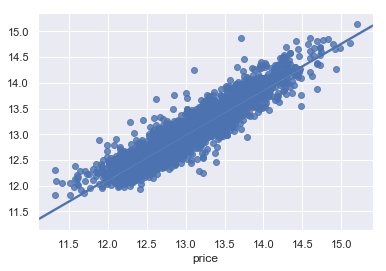

In [440]:
sns.regplot(y_test, y_predict)

In [441]:
r2_score(y_predict, y_test)

0.8482164808614048

In [442]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.866735328300192
0.8482164808614048


In [443]:
y_predict_train = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03284285996332593
Test Mean Squarred Error: 0.03584491734512773
1.0914066979901889


In [444]:
model_results = []
model_results.append(["Ridge - alpha .5", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [445]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [446]:
lasso.score(X_train, y_train)

0.00859596158756648

In [447]:
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.2776094603804716
Test Mean Squarred Error: 0.03584491734512773
0.12911994171956986


In [448]:
#adj = r_adjusted(lasso.score(X_train, y_train), X, y)
#model_results.append(["Lasso - alpha 1", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [449]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [450]:
lasso.score(X_train, y_train)

0.8501491122356233

In [451]:
r2_score(y_predict, y_test)

0.8482164808614048

In [452]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [453]:
alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)

In [454]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

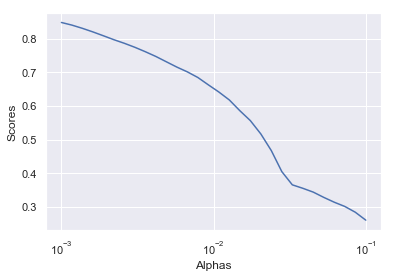

In [455]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [456]:
lasso = Lasso(alpha=.0001)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.8812582507500257

In [457]:
from sklearn.metrics import mean_squared_error
y_predict_train = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.033249645610385674
Test Mean Squarred Error: 0.03584491734512773
1.078054117182272


In [458]:
adj = r_adjusted(lasso.score(X_train, y_train), X_train, y_train)
model_results.append(["Lasso - alpha .0001", lasso.score(X_train, y_train), adj, train_mse, test_mse])

In [459]:
from sklearn.linear_model import ElasticNet
alphas = np.logspace(-3, -1, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [460]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([0.001  , 0.00117, 0.00137, 0.00161, 0.00189, 0.00221, 0.00259,
       0.00304, 0.00356, 0.00418, 0.00489, 0.00574, 0.00672, 0.00788,
       0.00924, 0.01083, 0.01269, 0.01487, 0.01743, 0.02043, 0.02395,
       0.02807, 0.0329 , 0.03857, 0.0452 , 0.05298, 0.0621 , 0.07279,
       0.08532, 0.1    ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

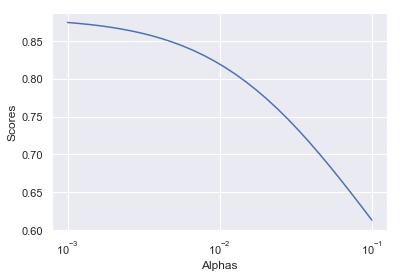

In [461]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [462]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [463]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03308867004274689
Test Mean Squarred Error: 0.03584491734512773
1.0832988240029011


In [464]:
elastic.score(X_train, y_train)

0.8818331296739071

In [465]:
L1_ratios = np.linspace(0, 1, 3)

tuned_parameters = [{'l1_ratio': L1_ratios}]
n_folds = 3

clf = GridSearchCV(elastic, tuned_parameters, cv=n_folds, refit=False)

In [466]:
clf.fit(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'l1_ratio': array([0. , 0.5, 1. ])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

Text(0, 0.5, 'Scores')

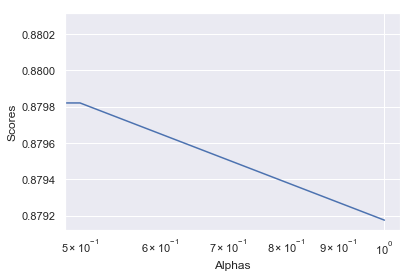

In [467]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(L1_ratios, scores)
plt.xlabel("Alphas")
plt.ylabel("Scores")

In [468]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=.0001, l1_ratio=.00001)
elastic.fit(X_train, y_train)

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1e-05,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [469]:
elastic.score(X_train, y_train)

0.8822741626603932

In [470]:
from sklearn.metrics import mean_squared_error
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.032965173542183486
Test Mean Squarred Error: 0.03584491734512773
1.087357155855989


In [471]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="neg_mean_squared_error")

In [472]:
cvs

array([-0.03211149, -0.0308572 , -0.03195582, -0.03224113, -0.03315372,
       -0.02922012, -0.03358944, -0.03191999, -0.03336031, -0.03476823,
       -0.03555982, -0.03452903, -0.03423847, -0.03485038, -0.03564086,
       -0.03846914, -0.04136617, -0.03224612, -0.03350148, -0.03232661])

In [473]:
cvs = cross_val_score(lasso, X_train, y_train, cv=20, scoring="r2")

In [474]:
cvs

array([0.88687881, 0.89068454, 0.88778171, 0.88450118, 0.87901469,
       0.89297816, 0.88198782, 0.88178738, 0.88006584, 0.88182092,
       0.86954826, 0.88038761, 0.87859814, 0.87487708, 0.87775169,
       0.85748341, 0.86101863, 0.88851221, 0.87314705, 0.87365046])

In [475]:
lasso.coef_

array([-2.16883186e-03,  4.55341810e-02,  1.16080430e+00,  8.06964156e-01,
       -2.26357158e-02,  1.11248404e+00,  0.00000000e+00, -1.44886296e-01,
        1.19311355e+00, -4.11942519e-01,  4.70482430e-01,  3.88163565e-02,
        4.46369996e-02,  5.11023186e-02,  3.03190135e-04, -2.53714765e-01,
       -2.60019125e-01, -2.84737487e-01,  4.76754638e-01,  1.12844065e-01,
        9.03451427e-02,  3.79630696e-02,  5.22872059e-02,  6.21418572e-02,
       -3.36054283e-01, -1.89390301e-01, -3.09860007e-01,  0.00000000e+00,
       -3.46303385e-01, -0.00000000e+00,  5.40044499e-02, -3.72664121e-01,
        1.12418043e-01, -2.51568888e-01, -2.69839070e-01, -3.77624688e-01,
        7.53274873e-02, -2.12915315e-01, -7.53804661e-02,  5.37872348e-01,
        2.81848762e-01, -2.16320509e-01,  6.24762494e-02, -3.78664816e-02,
       -3.86837235e-02, -2.85375947e-01, -1.59023059e-01, -2.25445084e-01,
       -1.03822770e-01,  4.72132652e-03, -1.30097578e-01, -2.52181697e-01,
       -1.48378594e-02,  

In [476]:
list(zip(lasso.coef_, X_train.columns))

[(-0.0021688318631551714, 'bedrooms'),
 (0.04553418100933274, 'bathrooms'),
 (1.160804300571658, 'sqft_living'),
 (0.8069641560807768, 'sqft_lot'),
 (-0.022635715818865414, 'floors'),
 (1.1124840395081514, 'sqft_above'),
 (0.0, 'sqft_basement'),
 (-0.14488629555179255, 'yr_built'),
 (1.193113545063987, 'lat'),
 (-0.41194251915609525, 'long'),
 (0.4704824302975772, 'sqft_living15'),
 (0.038816356476321374, 'sqft_lot15'),
 (0.0446369996193739, 'is_renovated'),
 (0.05110231863925336, 'has_basement'),
 (0.0003031901350873151, 'blt_or_renov'),
 (-0.2537147654218826, 'ZIP_98001'),
 (-0.26001912541152916, 'ZIP_98002'),
 (-0.2847374866532254, 'ZIP_98003'),
 (0.4767546381776712, 'ZIP_98004'),
 (0.11284406504665477, 'ZIP_98005'),
 (0.09034514265238267, 'ZIP_98006'),
 (0.037963069621609474, 'ZIP_98007'),
 (0.05228720592106337, 'ZIP_98008'),
 (0.0621418572339145, 'ZIP_98010'),
 (-0.3360542831398879, 'ZIP_98011'),
 (-0.18939030100866294, 'ZIP_98014'),
 (-0.30986000693850474, 'ZIP_98019'),
 (0.0, 'Z

In [477]:
coefs = list(zip(lasso.coef_, X_train.columns))

In [478]:
coefs = [x for x in coefs if "ZIP" in x[1]]

In [479]:
coefs.sort(key=lambda x: x[0])

In [480]:
coefs

[(-0.4333799846571415, 'ZIP_98168'),
 (-0.39749236080843964, 'ZIP_98155'),
 (-0.37762468810516564, 'ZIP_98032'),
 (-0.37266412102476865, 'ZIP_98028'),
 (-0.3629951822421112, 'ZIP_98133'),
 (-0.3515712158458973, 'ZIP_98178'),
 (-0.3463033854034708, 'ZIP_98023'),
 (-0.3360542831398879, 'ZIP_98011'),
 (-0.33410761689722435, 'ZIP_98198'),
 (-0.30986000693850474, 'ZIP_98019'),
 (-0.3095117180825598, 'ZIP_98188'),
 (-0.28537594703970565, 'ZIP_98055'),
 (-0.2847374866532254, 'ZIP_98003'),
 (-0.27233648466549476, 'ZIP_98146'),
 (-0.2707247721706527, 'ZIP_98106'),
 (-0.2698390700853742, 'ZIP_98031'),
 (-0.26001912541152916, 'ZIP_98002'),
 (-0.2588391714558301, 'ZIP_98177'),
 (-0.2586210627621662, 'ZIP_98148'),
 (-0.2583353454231138, 'ZIP_98077'),
 (-0.2537147654218826, 'ZIP_98001'),
 (-0.25218169718187805, 'ZIP_98072'),
 (-0.25156888787809756, 'ZIP_98030'),
 (-0.23655056488032664, 'ZIP_98108'),
 (-0.2254450835399198, 'ZIP_98058'),
 (-0.21632050851543227, 'ZIP_98042'),
 (-0.212915315014372, 'ZIP

In [481]:
adj = r_adjusted(elastic.score(X_train, y_train), X_train, y_train)
model_results.append(["Elastic - alpha=.0001, l1_ratio=.00001", elastic.score(X_train, y_train), adj, train_mse, test_mse])

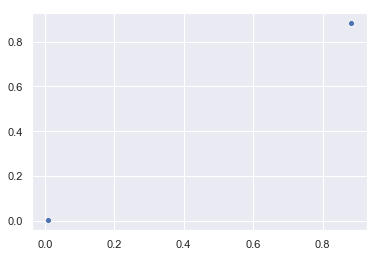

In [482]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
sns.scatterplot(r2, r2_adj)

In [483]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [484]:
y_predict_train = elastic.predict(X_train)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.032965173542183486
Test Mean Squarred Error: 0.03584491734512773
1.087357155855989


In [485]:
linreg.score(X_train, y_train)

0.8828244101859866

In [486]:
adj = r_adjusted(linreg.score(X_train, y_train), X_train, y_train)

In [487]:
model_results.append(["Linear Regression", linreg.score(X_train, y_train), adj, train_mse, test_mse])

In [495]:


r2 = [x[1] for x in model_results]
r2_adj = [x[2] for x in model_results]
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(r2, r2_adj)

for i, entry in enumerate(model_results):
    ax.annotate(entry[0], (r2[i], r2_adj[i]))

#ax.margins(x=0, y=-0.45)


IndexError: invalid index to scalar variable.

In [491]:
model_results

[['Ridge - alpha .5',
  0.882710971175009,
  0.8821433819982466,
  0.03284285996332593,
  0.03584491734512773],
 ['Lasso - alpha 1',
  0.00859596158756648,
  0.0037983244373690495,
  0.2776094603804716,
  0.03584491734512773],
 ['Lasso - alpha .0001',
  0.8812582507500257,
  0.880539064801508,
  0.033249645610385674,
  0.03584491734512773],
 ['Elastic - alpha=.0001, l1_ratio=.00001',
  0.8822741626603932,
  0.8815611298094631,
  0.032965173542183486,
  0.03584491734512773],
 ['Linear Regression',
  0.8828244101859866,
  0.8821147100322007,
  0.032965173542183486,
  0.03584491734512773]]

In [398]:
print("Ratio of MSEs")
["%s - %s" % (x[0], x[3]/x[4]) for x in model_results]

Ratio of MSEs


['Ridge - alpha .5 - 1.069537109697225',
 'Lasso - alpha .0001 - 1.0819770506237878',
 'Elastic - alpha=.0001, l1_ratio=.00001 - 1.0735039738476828',
 'Linear Regression - 1.0218445083571395']